In [1]:
import os
import glob

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import ParameterDict

import torchvision
from torchvision import transforms

import kornia as K
import cv2

import matplotlib.pyplot as plt
from PIL import Image

from AugmentationsDataset import *
from kAugmentations.kRotation import *
from kAugmentations.kBrightness import *

from utils import plot_tensor, show_sample, learning_grid, create_loss_map

In [2]:
### --- Config --- ###
augmentation_name = 'brightness'
main_parameter_name = 'brightness_factor'
aug_bounds = (0.0, 1.0)
param_linspace = np.linspace(aug_bounds[0],aug_bounds[1],400)

# dataset
target_param_val = .5
target_aug_constructor = K.enhance.AdjustBrightness
target_aug_constructor_args = {
    'brightness_factor': target_param_val,
}

init_param_val = 0.

# training
criterion_constructor = nn.MSELoss
criterion_constructor_args = {}

batch_size = 64
epochs = 1

optimizer_constructor = optim.SGD
optimizer_constructor_args = {
    'lr': 0.01,
    'momentum': 0.9,
}

scheduler_constructor = optim.lr_scheduler.CosineAnnealingLR
scheduler_constructor_args = {
    'T_max':100,
    'eta_min':0.1,
    'verbose':True,
}

scheduler_warmup = 100
scheduler_freq = 10
use_scheduler=False

early_stopping = 500

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# paths:
run_name = f'{augmentation_name}-init-{init_param_val}_target-{target_param_val}'

figures_dir = f'figures'
run_figures_dir = f'{figures_dir}/{run_name}'

gifs_dir = f'gifs'
run_gif_name = f'{gifs_dir}/{run_name}.gif'

os.makedirs(run_figures_dir, exist_ok=True)
os.makedirs(gifs_dir, exist_ok=True)
os.makedirs(f'{run_figures_dir}/results', exist_ok=True)
os.makedirs(f'{run_figures_dir}/learning_progress', exist_ok=True)


In [3]:
source_transform = transforms.Compose([
    transforms.ToTensor()
])

target_augmentations = transforms.Compose([
    K.augmentation.container.ImageSequential(
        target_aug_constructor(**target_aug_constructor_args)
    )
])

target_transform = transforms.Compose([
    # transforms.ToTensor(),
    target_augmentations
])

In [4]:
glob_path = '../data/tiny-imagenet-200/train/*/images/*'
dataset = AugmentationsDataset(glob_path,
                               source_transform, target_transform,)

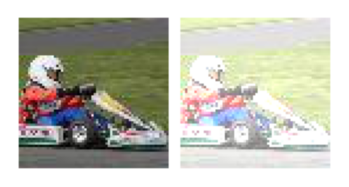

In [5]:
show_sample(dataset[0])

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [7]:
model = K.augmentation.ImageSequential(
    # kRotation(init_param=init_param_val),
    kBrightness(init_param=init_param_val)
)
model.to(device)

ImageSequential(
  (kBrightness_0): kBrightness()
)

In [8]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

kBrightness_0.trans_param tensor([0.], device='cuda:0')


In [9]:
criterion = criterion_constructor(**criterion_constructor_args)
optimizer = optimizer_constructor(model.parameters(), **optimizer_constructor_args)
scheduler = scheduler_constructor(optimizer, **scheduler_constructor_args)

Adjusting learning rate of group 0 to 1.0000e-02.


In [10]:
losses = []
lrs = []
p_progress = []
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        source_images, target_images = data
        source_images, target_images = source_images.to(device), target_images.to(device)
        
        optimizer.zero_grad()

        output_images = model(source_images)
        loss = criterion(output_images, target_images)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        running_loss += loss.item()
        print_every = 10
        if i % print_every == print_every - 1:
            print(f'[Epoch: {epoch+1} | Batch: {i+1} | MSE Loss: {running_loss/print_every:.3f} | ', end='')
            print(f'{main_parameter_name}: {model[0].get_param_val()}]')
            running_loss = 0.0

            with torch.no_grad():
                img_dict = {
                    "source": dataset[0][0],
                    "model's output": model(dataset[0][0].unsqueeze(0).to(device)).squeeze(),
                    "target": dataset[0][1]
                }
                learning_grid(img_dict, save=f'{run_figures_dir}/learning_progress/epoch-{epoch+1:02}_batch-{i+1:05}.png')
        
        lrs.append(scheduler.get_last_lr())
        p_progress.append(model[0].get_param_val())
        if use_scheduler:
            if i % scheduler_freq == scheduler_freq - 1 and i > scheduler_warmup:
                scheduler.step()


        if i == early_stopping:
            break

print('Finished Training.')

[Epoch: 1 | Batch: 10 | MSE Loss: 0.121 | brightness_factor: 0.28673818707466125]
[Epoch: 1 | Batch: 20 | MSE Loss: 0.008 | brightness_factor: 0.5665743947029114]
[Epoch: 1 | Batch: 30 | MSE Loss: 0.006 | brightness_factor: 0.6273779273033142]
[Epoch: 1 | Batch: 40 | MSE Loss: 0.006 | brightness_factor: 0.578278124332428]
[Epoch: 1 | Batch: 50 | MSE Loss: 0.001 | brightness_factor: 0.5148886442184448]
[Epoch: 1 | Batch: 60 | MSE Loss: 0.000 | brightness_factor: 0.483464777469635]
[Epoch: 1 | Batch: 70 | MSE Loss: 0.000 | brightness_factor: 0.48396316170692444]
[Epoch: 1 | Batch: 80 | MSE Loss: 0.000 | brightness_factor: 0.4951831102371216]
[Epoch: 1 | Batch: 90 | MSE Loss: 0.000 | brightness_factor: 0.50238037109375]
[Epoch: 1 | Batch: 100 | MSE Loss: 0.000 | brightness_factor: 0.5032303333282471]
[Epoch: 1 | Batch: 110 | MSE Loss: 0.000 | brightness_factor: 0.5012615919113159]
[Epoch: 1 | Batch: 120 | MSE Loss: 0.000 | brightness_factor: 0.49970364570617676]
[Epoch: 1 | Batch: 130 | M

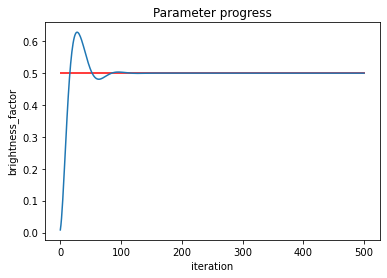

In [11]:
plt.plot(p_progress, zorder=7)
plt.hlines(y=target_param_val, xmin=0, xmax=[len(p_progress)], color='r',zorder=5)
plt.xlabel('iteration')
plt.ylabel(f'{main_parameter_name}')
plt.title('Parameter progress')
plt.savefig(f'{run_figures_dir}/results/parameter_progress__{main_parameter_name}.png')

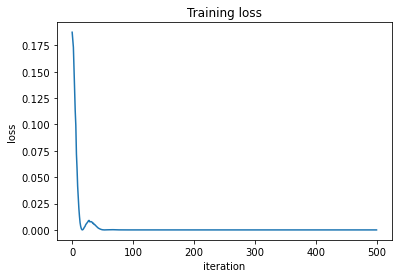

In [12]:
plt.plot(losses)
plt.title('Training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig(f'{run_figures_dir}/results/training_loss.png')

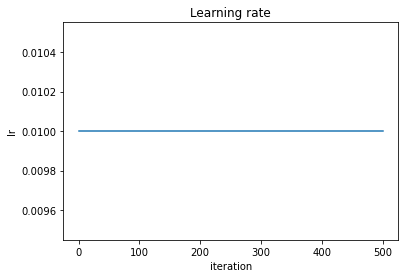

In [13]:
plt.plot(lrs)
plt.title('Learning rate')
plt.xlabel('iteration')
plt.ylabel('lr')
plt.savefig(f'{run_figures_dir}/results/learning_rate.png')

In [14]:
num_frames = 50
# filepaths
fp_in = f"{run_figures_dir}/learning_progress/epoch-*"
fp_out = run_gif_name

imgs = iter([Image.open(f) for f in sorted(glob.glob(fp_in))][:num_frames])
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=75, loop=0)